In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

from gi import event_size, fiducial_df, twocluster_df, histoplot, scatter_xy, event_mult, d12, dtz, plot_amplitude
from imgs import  plot_image2

In [2]:
g4dir = "/Users/jjgomezcadenas/Data/G4Prods/crystalGI/G4BGO"
imgdir = "/Users/jjgomezcadenas/Data/G4Prods/crystalGI/BGO"
fsp = "sensor_positions.csv"

## Reads and check the data generated by PreparaData.py 

In [3]:
img =np.load("/Users/jjgomezcadenas/Data/G4Prods/crystalGI/BGO/images_1.npy")

In [4]:
img[0]

array([[ 47.,  78.,  83.,  76.,  79.,  80.,  34.,  33.],
       [ 54.,  76.,  92., 105., 105.,  82.,  66.,  37.],
       [ 34.,  89.,  79.,  87.,  90.,  75.,  63.,  38.],
       [ 47.,  50.,  70.,  63.,  71.,  50.,  47.,  22.],
       [ 28.,  38.,  57.,  63.,  63.,  55.,  46.,  31.],
       [ 30.,  40.,  32.,  38.,  45.,  40.,  36.,  23.],
       [ 31.,  26.,  31.,  29.,  30.,  27.,  36.,  27.],
       [ 21.,  28.,  22.,  25.,  22.,  29.,  20.,  25.]])

In [5]:
dfg = pd.read_csv("/Users/jjgomezcadenas/Data/G4Prods/crystalGI/BGO/metadata_1.csv", header=0)
dfg.head(10)

,event,etot,ntrk,t1,x1,y1,z1,e1,t2,x2,y2,z2,e2
0,20000,511.0,1,4.6,-13.2,-1.5,-9.7,511.0,4.6,-13.2,-1.5,-9.7,511.0
1,20001,511.0,1,34.4,1.4,-11.3,-0.8,511.0,34.4,1.4,-11.3,-0.8,511.0
2,20002,511.0,1,17.0,-9.4,8.3,-6.0,511.0,17.0,-9.4,8.3,-6.0,511.0
3,20004,511.0,2,45.4,6.7,-6.2,2.5,253.9,56.7,4.3,-3.8,2.5,257.1
4,20005,511.0,1,0.1,20.1,-4.8,-11.1,511.0,0.1,20.1,-4.8,-11.1,511.0
5,20006,511.0,2,4.5,-11.9,-0.6,-9.7,288.7,19.0,-15.3,1.6,-11.0,222.3
6,20007,511.0,1,32.4,5.3,-18.2,-1.4,511.0,32.4,5.3,-18.2,-1.4,511.0
7,20008,511.0,2,26.7,7.6,-19.9,-3.1,63.3,56.2,4.5,-16.6,4.5,447.7
8,20010,511.0,1,21.8,-18.4,6.7,-4.6,511.0,21.8,-18.4,6.7,-4.6,511.0
9,20011,511.0,3,22.9,-2.1,15.2,-4.2,277.8,24.5,-2.5,15.4,-4.3,10.6


In [6]:
print(f" Relative size must be the same (1) -> {img.shape[0]/event_size(dfg)}") 

 Relative size must be the same (1) -> 1.0


In [7]:
dfs = pd.read_csv(f"{g4dir}/{fsp}", header=0)
dfs.head(10)

,sensor_id,sensor_x,sensor_y,sensor_z
0,0,-21,-21,11.7
1,1,-21,-15,11.7
2,2,-21,-9,11.7
3,3,-21,-3,11.7
4,4,-21,3,11.7
5,5,-21,9,11.7
6,6,-21,15,11.7
7,7,-21,21,11.7
8,8,-15,-21,11.7
9,9,-15,-15,11.7


In [8]:
x_spatial = dfs.sensor_x.values
y_spatial = dfs.sensor_y.values
evtsel = dfg.event.values

xg1 = -13.2, yg1 =-1.5
x = -13.2, y =-1.5
xt1 = 1.4857142857142858, yt1 =3.7142857142857144
xg2 = -13.2, yg2 =-1.5
x = -13.2, y =-1.5
xt2 = 1.4857142857142858, yt1 =3.7142857142857144


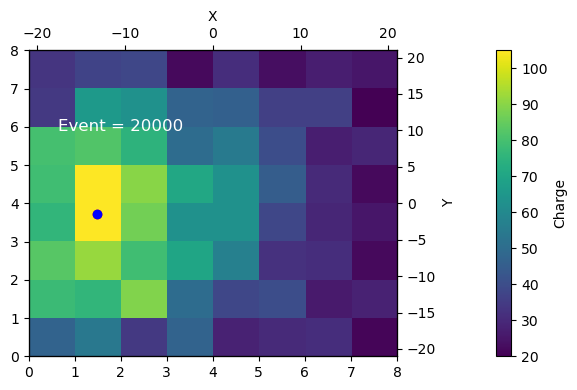

In [9]:
plot_image2(img[0], dfg,  evtsel[0], x_spatial, y_spatial, figsize=(6, 4))

xg1 = 22.0, yg1 =-9.6
x = 21, y =-9.6
xt1 = 8.0, yt1 =2.1714285714285717
xg2 = 22.0, yg2 =-9.6
x = 21, y =-8.9
xt2 = 8.0, yt1 =2.3047619047619046


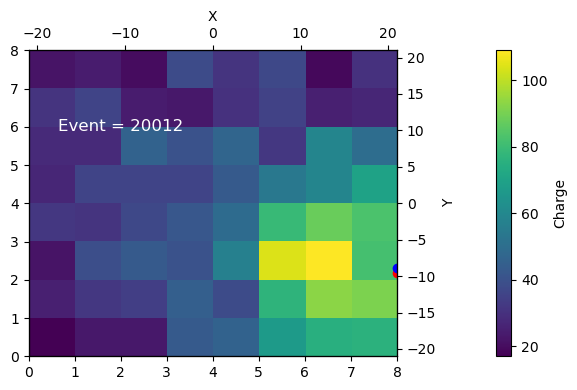

In [10]:
plot_image2(img[10], dfg,  evtsel[10], x_spatial, y_spatial, figsize=(6, 4))

xg1 = -21.6, yg1 =10.8
x = -21, y =10.8
xt1 = 0.0, yt1 =6.057142857142857
xg2 = -21.6, yg2 =10.8
x = -21, y =18.2
xt2 = 0.0, yt1 =7.466666666666667


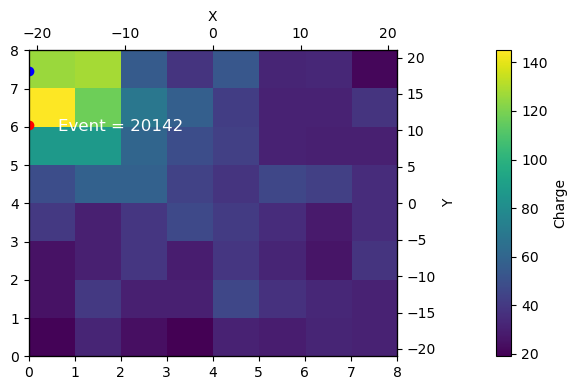

In [11]:
plot_image2(img[100], dfg,  evtsel[100], x_spatial, y_spatial, figsize=(6, 4))

xg1 = 0.6, yg1 =4.8
x = 0.6, y =4.8
xt1 = 4.114285714285715, yt1 =4.914285714285715
xg2 = 0.6, yg2 =4.8
x = 0.6, y =4.8
xt2 = 4.114285714285715, yt1 =4.914285714285715


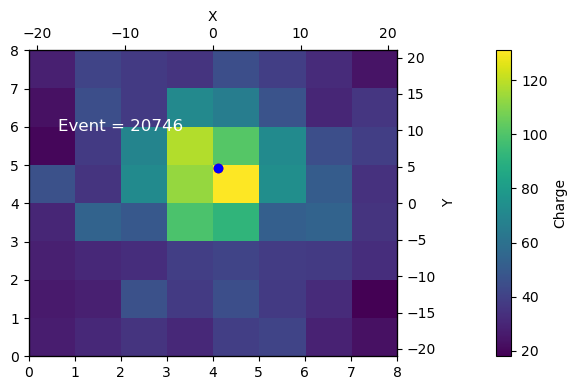

In [13]:
plot_image2(img[500], dfg,  evtsel[500], x_spatial, y_spatial, figsize=(6, 4))